In [49]:
!pip install pennylane
!pip install qiskit
from IPython.display import clear_output
clear_output()

In [ ]:
import os

def restart_runtime():
  os.kill(os.getpid(), 9)
restart_runtime()

In [1]:
# Mount Google Drive
from google.colab import drive # import drive from google colab
 
ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)
 
drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
from numpy import loadtxt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA

# Data Load

In [3]:
# load dataset

label = 0

X = loadtxt('C:/Users/user/quantum_image_classifier/Image Preprocessing/Dataset One-vs-All/x_train_4features_' + str(0) + '.txt', delimiter=',')

X_test = loadtxt('C:/Users/user/quantum_image_classifier/Image Preprocessing/Dataset One-vs-All/x_test_4features_' + str(0) + '.txt', delimiter=',')

OSError: ignored

In [ ]:
X.shape[0]

In [ ]:
Y = np.zeros((X.shape[0],))
Y[:int(X.shape[0]/2)] = 1
Y[int(X.shape[0]/2):] = -1

Y_test = np.zeros((X_test.shape[0],))
Y_test[:int(X_test.shape[0]/2)] = 1
Y_test[int(X_test.shape[0]/2):] = -1

In [ ]:
print(X.shape, Y.shape)
print(X_test.shape, Y_test.shape)

(1008, 4) (1008,)
(216, 4) (216,)


# Data Load & Prep

In [4]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [5]:
x_train_flatten = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/255.0
x_test_flatten = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/255.0

print(x_train_flatten.shape, y_train.shape)
print(x_test_flatten.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


In [6]:
x_train_0 = x_train_flatten[y_train == 0]
x_train_1 = x_train_flatten[y_train == 1]
x_train_2 = x_train_flatten[y_train == 2]
x_train_3 = x_train_flatten[y_train == 3]
x_train_4 = x_train_flatten[y_train == 4]
x_train_5 = x_train_flatten[y_train == 5]
x_train_6 = x_train_flatten[y_train == 6]
x_train_7 = x_train_flatten[y_train == 7]
x_train_8 = x_train_flatten[y_train == 8]
x_train_9 = x_train_flatten[y_train == 9]

x_train_list = [x_train_0, x_train_1, x_train_2, x_train_3, x_train_4, x_train_5, x_train_6, x_train_7, x_train_8, x_train_9]

print(x_train_0.shape)
print(x_train_1.shape)
print(x_train_2.shape)
print(x_train_3.shape)
print(x_train_4.shape)
print(x_train_5.shape)
print(x_train_6.shape)
print(x_train_7.shape)
print(x_train_8.shape)
print(x_train_9.shape)

(5923, 784)
(6742, 784)
(5958, 784)
(6131, 784)
(5842, 784)
(5421, 784)
(5918, 784)
(6265, 784)
(5851, 784)
(5949, 784)


In [20]:
Y = np.zeros((1200,), dtype=int)

a = x_train_0[:300, :]

for i in range(3):
  a = np.concatenate((a, x_train_list[i+1][:300, :]), axis=0)
  Y[300*(i+1):300*(i+2)] += i+1

a.shape, Y.shape

((1200, 784), (1200,))

In [25]:
Y[Y == 3].shape

(300,)

In [26]:
def normalize(X, use_params=False, params=None):
    """Normalize the given dataset X
    Args:
        X: ndarray, dataset
    
    Returns:
        (Xbar, mean, std): tuple of ndarray, Xbar is the normalized dataset
        with mean 0 and standard deviation 1; mean and std are the 
        mean and standard deviation respectively.
    
    Note:
        You will encounter dimensions where the standard deviation is
        zero, for those when you do normalization the normalized data
        will be NaN. Handle this by setting using `std = 1` for those 
        dimensions when doing normalization.
    """
    if use_params:
        mu = params[0]
        std_filled = [1]
    else:
        mu = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        #std_filled = std.copy()
    #std_filled[std==0] = 1.
    Xbar = (X - mu)/(std + 1e-8)
    return Xbar, mu, std


In [27]:
Xbar, _, _ = normalize(a)
print(Xbar.shape)

num_component = 4
pca = PCA(n_components=num_component, svd_solver='full')
pca.fit(a)

(1200, 784)


PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [28]:
np.cumsum(pca.explained_variance_ratio_)

tensor([0.17300065, 0.25596241, 0.32625588, 0.38633023], requires_grad=True)

In [29]:
X = pca.transform(a)

In [53]:
Y = tf.keras.utils.to_categorical(Y)

In [54]:
X.shape, Y.shape

((1200, 4), (1200, 4))

# Create Quantum Model

In [14]:
%matplotlib inline

import pennylane as qml
from pennylane import numpy as np
import numpy
from pennylane.optimize import *

from qiskit import *
from qiskit.providers.aer.noise import NoiseModel

In [46]:
dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev)
def circuit(x, y):
    qml.RZ(x, wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(y, wires=1)
    return qml.probs(wires=[0, 1])

In [47]:
circuit(0.5, 0.5)

array([0.93879128, 0.06120872, 0.        , 0.        ])

In [58]:
np.average((Y[0, :] - circuit(0.5, 0.5))**2)

0.0018732536441655563

## Choose a Quantum Device

You can choose between several different backend (including the one ownwed by IBM)

In [32]:
def select_backend(num_qubit, selected, shots):
    if selected == 'pennylane_statevector_simulator':
        # PennyLane Statevector simulator
        dev = qml.device("default.qubit", wires=num_qubit)

    elif selected == 'qiskit_noisefree_qasm_simulator':
        # Qiskit QASM simulator (noise-free)
        dev = qml.device("qiskit.aer", wires=num_qubit, shots=shots, analytic=False, backend='qasm_simulator')

    elif selected == 'qiskit_noisy_qasm_simulator':
        # Qiskit QASM simulator + noise
        provider = IBMQ.load_account()
        backend = provider.get_backend('ibmq_athens')
        noise_model = NoiseModel.from_backend(backend)
        dev = qml.device("qiskit.aer", wires=num_qubit, shots=shots, noise_model = noise_model, analytic=False, backend='qasm_simulator')
        
    return dev

In [33]:
num_qubit = 2
dev = select_backend(2, 'pennylane_statevector_simulator', 1024)

## Loss and Acc Metric

In [95]:
# MSE
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + np.sum((l - p) ** 2)/4

    loss = loss / len(labels)
    return loss

# Cost-Sensitive Learning for Imbalanced Classification
def confusion_matrix_loss(labels, predictions):
    cost_matrix=np.array([[0, 0.9], [0.1, 0]])
    
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    # count the TP, TN, FP, and FN
    for l, p in zip(labels, predictions):
        if l == 1:
            if p == 1:
                TP += 1
            else:
                FN += 1
        else:
            if p == 1:
                FP += 1
            else:
                TN += 1
            
    # create the confusion matrix
    CM = np.array([[TN, FN], [FP, TP]])
    
    # calculate loss
    loss = float(np.sum(CM*cost_matrix))/len(labels)

    return loss

# true predictions/total predictions
def accuracy(labels, predictions):
    acc = 0
    for l, p in zip(labels, predictions):
        if abs(np.argmax(l) - np.argmax(p)) < 1e-5:
            acc = acc + 1
    acc = acc / len(labels)

    return acc

## Quantum Amplitude Encoding Function

In [96]:
# a function to calculate the angle β

def beta(s, j, X_sample):
    # numerator index
    index_num = (2*j-1)*(2**(s-1))
    # denominator index
    index_den = (j-1)*(2**s)
    
    num = np.sqrt(np.sum(abs(X_sample[index_num : index_num+2**(s-1)])**2))
    den = np.sqrt(np.sum(abs(X_sample[index_den : index_den+2**(s)])**2))
    
    if den == 0:
        #print("Zero denominator!")
        beta = 0
    else:
        beta = 2*np.arcsin(num/den)
    
    return beta

In [97]:
def get_angles(x):
    beta_2_1 = beta(2, 1, x)
    beta_1_2 = beta(1, 2, x)
    beta_1_1 = beta(1, 1, x)
    
    return np.array([beta_2_1, beta_1_2, beta_1_1])

In [98]:
def U3_gate(θ, qubit):
    qml.RX(np.pi/2, wires=qubit)
    qml.RZ(θ, wires=qubit)
    qml.RX(-np.pi/2, wires=qubit)

In [99]:
def statepreparation(a):
    qml.RY(a[0], wires=0)
    
    qml.RX(np.pi/2, wires=1)
    qml.RZ(a[1]/2, wires=1)
    qml.RX(-np.pi/2, wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(np.pi/2, wires=1)
    qml.RZ(-a[1]/2, wires=1)
    qml.RX(-np.pi/2, wires=1)
    qml.CNOT(wires=[0, 1])
    
    qml.PauliX(wires=0)
    qml.RX(np.pi/2, wires=1)
    qml.RZ(a[2]/2, wires=1)
    qml.RX(-np.pi/2, wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(np.pi/2, wires=1)
    qml.RZ(-a[2]/2, wires=1)
    qml.RX(-np.pi/2, wires=1)
    qml.CNOT(wires=[0, 1])
    qml.PauliX(wires=0)


In [100]:
def statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(-a[1]/2, wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[1]/2, wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(-a[2]/2, wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2]/2, wires=1)
    qml.PauliX(wires=0)

In [101]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0])
ang = get_angles(x)


@qml.qnode(dev)
def test(angles=None):

    statepreparation(angles)

    return qml.expval(qml.PauliZ(0))


test(angles=ang)

print("x               : ", x)
print("angles          : ", ang)
print("amplitude vector: ", np.real(dev._state))

x               :  [0.53896774 0.79503606 0.27826503 0.        ]
angles          :  [0.56397465 0.         1.95009208]
amplitude vector:  [[0.53896774 0.79503606]
 [0.27826503 0.        ]]


## Define the Layer

In [102]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

## Build the Quantum Circuit, Define Cost Function, Create VQC

In [137]:
@qml.qnode(dev)
def circuit(weights, angles=None):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.probs(wires=[0, 1])


def variational_classifier(var, angles=None):
    weights = var[0]
    bias = var[1]
    return circuit(weights, angles=angles) + bias


def cost(weights, features, labels):
    predictions = [variational_classifier(weights, angles=f) for f in features]
    return square_loss(labels, predictions)

# Data Prep

## Data (Padding), Normalization and Data Encoding

In [71]:
# train and val

print("First X train sample (original)  :", X[0])

# # pad the vectors to size 2^2 with constant values
# padding = 0.3 * np.ones((len(X), 1))
# X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
# print("First X sample (padded)    :", X_pad[0])

X_pad = X.copy()

# normalize each input
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T
print("First X train sample (normalized):", X_norm[0])

# angles for state preparation are new features
features = np.array([get_angles(x) for x in X_norm])
print("First features sample      :", features[0])

First X train sample (original)  : [ 4.54181354 -0.50514819 -2.50151231 -2.05000138]
First X train sample (normalized): [ 0.81125398 -0.09022904 -0.44681751 -0.3661691 ]
First features sample      : [1.23179163 1.37304297 0.22153291]


In [72]:
X[0, :]

array([ 4.54181354, -0.50514819, -2.50151231, -2.05000138])

In [73]:
sampel = 436
np.sqrt(X_norm[sampel, 0]**2 + X_norm[sampel, 1]**2 + X_norm[sampel, 2]**2 + X_norm[sampel, 3]**2)

tensor(1., requires_grad=True)

In [ ]:
print("First X test sample (original)  :", X_test[0])

# # pad the vectors to size 2^2 with constant values
# padding = 0.3 * np.ones((len(X_test), 1))
# X_pad = np.c_[np.c_[X_test, padding], np.zeros((len(X_test), 1))]
# print("First X sample (padded)    :", X_pad[0])

X_pad = X.copy()

# normalize each input
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T
print("First X test sample (normalized):", X_norm[0])

# angles for state preparation are new features
feats_test = np.array([get_angles(x) for x in X_norm])
print("First test features sample      :", feats_test[0])

First X test sample (original)  : [ 4.83885093  0.44290373  0.99533214 -0.38530635]
First X test sample (normalized): [ 0.78092007 -0.22759276  0.46029957 -0.35565388]
First test features sample      : [1.24161413 1.31568975 0.56717374]


In [ ]:
sampel = 17
np.sqrt(X_norm[sampel, 0]**2 + X_norm[sampel, 1]**2 + X_norm[sampel, 2]**2 + X_norm[sampel, 3]**2)

1.0

In [74]:
# split X and y to train and validation

from sklearn.model_selection import train_test_split

feats_train, feats_val, Y_train, Y_val = train_test_split(features, Y, test_size=200/1200, random_state=2020)

X_train, X_val, _, _ = train_test_split(X, Y, test_size=200/1200, random_state=2020)

In [76]:
print(X_train.shape, feats_train.shape, Y_train.shape)
print(X_val.shape, feats_val.shape, Y_val.shape)
#print(X_test.shape, feats_test.shape, Y_test.shape)

(1000, 4) (1000, 3) (1000, 4)
(200, 4) (200, 3) (200, 4)


# Training

## Qubits, Layers and Weights Initialization

In [139]:
# First we initialize the hyperparameters

num_qubits = 2  # 4 label = 4 class = log2(4) quibits = 2 qubits
num_layers = 12  # QNN layer
learning_rate = 0.01

opt = RMSPropOptimizer(stepsize=learning_rate)
batch_size = 16
max_iter = 250

var_init = (0.01 * np.random.randn(num_layers, num_qubits, 3), 0.0)  # weights and bias initialization

In [140]:
num_train = X_train.shape[0]
num_train

1000

## Training Iteration

In [141]:
# training

# array to save the training & val accuracy and loss history as the training goes
train_history = np.array([])
val_history = np.array([])
train_loss_history = np.array([])
val_loss_history = np.array([])
iter_history = np.array([])

# WARNING!
var = var_init


# train the variational classifier
for it in range(max_iter):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    var = opt.step(lambda v: cost(v, feats_train_batch, Y_train_batch), var)
    # Compute predictions on train and validation set
    predictions_train = [variational_classifier(var, angles=f) for f in feats_train]
    predictions_val = [variational_classifier(var, angles=f) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    train_loss = cost(var, feats_train, Y_train)
    val_loss = cost(var, feats_val, Y_val)
    
    print(
        "Iter: {:5d} | Train Loss: {:0.7f} | Validation Loss: {:0.7f} | Train Acc: {:0.7f} | Validation Acc: {:0.7f} "
        "".format(it + 1, train_loss, val_loss, acc_train, acc_val)
    )
    
    iter_history = np.append(iter_history, it+1)
    train_loss_history = np.append(train_loss_history, train_loss)
    val_loss_history = np.append(val_loss_history, val_loss)
    train_history = np.append(train_history, acc_train)
    val_history = np.append(val_history, acc_val)
    
print("The training session is finished")

Iter:     1 | Train Loss: 0.2375727 | Validation Loss: 0.2395182 | Train Acc: 0.2530000 | Validation Acc: 0.2200000 
Iter:     2 | Train Loss: 0.2324171 | Validation Loss: 0.2350688 | Train Acc: 0.2400000 | Validation Acc: 0.2250000 
Iter:     3 | Train Loss: 0.2283173 | Validation Loss: 0.2325283 | Train Acc: 0.2270000 | Validation Acc: 0.2000000 
Iter:     4 | Train Loss: 0.2269832 | Validation Loss: 0.2332559 | Train Acc: 0.2350000 | Validation Acc: 0.2100000 
Iter:     5 | Train Loss: 0.2229801 | Validation Loss: 0.2276432 | Train Acc: 0.2300000 | Validation Acc: 0.2200000 
Iter:     6 | Train Loss: 0.2169391 | Validation Loss: 0.2185820 | Train Acc: 0.2530000 | Validation Acc: 0.2450000 
Iter:     7 | Train Loss: 0.2154313 | Validation Loss: 0.2184048 | Train Acc: 0.2700000 | Validation Acc: 0.2550000 
Iter:     8 | Train Loss: 0.2084964 | Validation Loss: 0.2137566 | Train Acc: 0.3080000 | Validation Acc: 0.2750000 
Iter:     9 | Train Loss: 0.2044359 | Validation Loss: 0.2092863

In [142]:
var

[array([[[-0.22388793, -0.03766961, -0.26254432],
         [-0.17592188,  0.24483819, -0.05272444]],
 
        [[-0.26351414,  0.04002217, -0.21099074],
         [ 0.07252444,  0.0329916 ,  0.10457793]],
 
        [[-0.20696593, -0.14074744, -0.23408235],
         [-0.07204895,  0.32900293,  0.03779968]],
 
        [[-0.2322499 ,  0.26519813, -0.17954417],
         [-0.06094833,  0.04405403, -0.02843326]],
 
        [[-0.14901164, -0.28559099, -0.17378614],
         [-0.04362639,  0.30324715,  0.05768037]],
 
        [[-0.1600881 ,  0.33844914, -0.12388483],
         [-0.13102417,  0.03707079, -0.10069396]],
 
        [[-0.11795498, -0.38459355, -0.09715653],
         [-0.02323102,  0.25085024,  0.0496453 ]],
 
        [[-0.09842784,  0.34949731, -0.05367628],
         [-0.06824465, -0.02335875, -0.04489077]],
 
        [[-0.0637779 , -0.40425673, -0.03219939],
         [ 0.00597702,  0.27105749,  0.09620193]],
 
        [[-0.03719783,  0.34798272, -0.00791766],
         [-0.09914847, 

In [107]:
var

[array([[[-0.2246721 ,  0.22219921, -0.14530355],
         [ 0.39727795,  0.51563351,  0.24847263]],
 
        [[-0.15627048, -0.43419547, -0.03970976],
         [-0.00263944,  0.17454305, -0.0736198 ]],
 
        [[-0.05116711,  0.39946621,  0.06770036],
         [ 0.14174251,  0.5958377 ,  0.03088761]],
 
        [[ 0.07019967, -0.50582061,  0.01160295],
         [ 0.03640856,  0.03024505, -0.02546629]],
 
        [[-0.01316573,  0.45177783,  0.10757354],
         [ 0.00516908,  0.48449971, -0.06513831]],
 
        [[ 0.13576881, -0.56004946, -0.00875292],
         [-0.05787608, -0.01228135, -0.01572296]]]), 0.004771013974602315]

In [127]:
acc_testing = 0
for i in range(10):
  train_id = i
  if np.argmax(variational_classifier(var, angles=feats_train[train_id, :])) == np.argmax(Y_train[train_id, :]):
    acc_testing += 1
  else:
    print(i)
    print(variational_classifier(var, angles=feats_train[train_id, :]))
    print(Y_train[train_id, :])

2
[0.04039058 0.02298903 0.35479151 0.60091293]
[0. 0. 1. 0.]
3
[0.13551843 0.62592525 0.1016443  0.15599608]
[1. 0. 0. 0.]
5
[0.00775344 0.0748596  0.49873812 0.43773289]
[0. 0. 0. 1.]
6
[0.19042907 0.59439668 0.171552   0.0627063 ]
[0. 0. 0. 1.]
7
[0.12597087 0.62501399 0.1153509  0.1527483 ]
[1. 0. 0. 0.]
9
[0.24417002 0.70619286 0.0414719  0.02724927]
[1. 0. 0. 0.]


In [130]:
accuracy(Y_train[:10, :], [variational_classifier(var, angles=f) for f in feats_train[:10,:]])

0.4

In [131]:
acc_testing

4

In [129]:
[variational_classifier(var, angles=f) for f in feats_train[:10,:]]

[array([0.27414884, 0.02188874, 0.14784856, 0.57519792]),
 array([0.40709362, 0.18428592, 0.20832976, 0.21937476]),
 array([0.04039058, 0.02298903, 0.35479151, 0.60091293]),
 array([0.13551843, 0.62592525, 0.1016443 , 0.15599608]),
 array([0.095277  , 0.56233795, 0.26051074, 0.10095836]),
 array([0.00775344, 0.0748596 , 0.49873812, 0.43773289]),
 array([0.19042907, 0.59439668, 0.171552  , 0.0627063 ]),
 array([0.12597087, 0.62501399, 0.1153509 , 0.1527483 ]),
 array([0.21781376, 0.67149208, 0.05919529, 0.07058293]),
 array([0.24417002, 0.70619286, 0.0414719 , 0.02724927])]

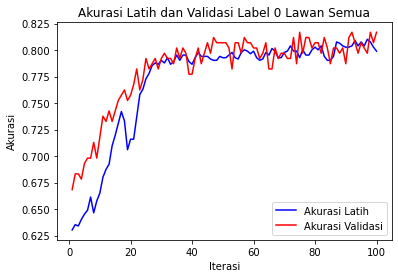

In [ ]:
# plot acc train, acc val

plt.plot(iter_history, train_history, color='blue', label='Akurasi Latih')
plt.plot(iter_history, val_history, color='red', label='Akurasi Validasi')

plt.ylabel('Akurasi')
plt.xlabel('Iterasi')
plt.title("Akurasi Latih dan Validasi Label " + str(label) + " Lawan Semua")

plt.legend()
plt.show()

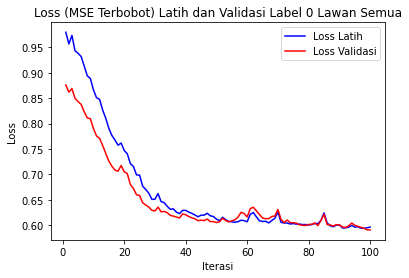

In [ ]:
# plot loss train, loss val

plt.plot(iter_history, train_loss_history, color='blue', label='Loss Latih')
plt.plot(iter_history, val_loss_history, color='red', label='Loss Validasi')

plt.ylabel('Loss')
plt.xlabel('Iterasi')
plt.title("Loss (MSE Terbobot) Latih dan Validasi Label " + str(label) + " Lawan Semua")

plt.legend()
plt.show()

In [ ]:
train_val_acc_hist = np.concatenate((train_history.reshape(-1,1), val_history.reshape(-1,1)), axis=1)
train_val_loss_hist = np.concatenate((train_loss_history.reshape(-1,1), val_loss_history.reshape(-1,1)), axis=1)

In [ ]:
# save numpy array as csv file
from numpy import asarray
from numpy import savetxt, loadtxt

def save_to_csv(data, file_name):
    # save to csv file
    savetxt(file_name, data, delimiter=',')
    
def load_from_csv(file_name):
    # load from csv file
    return loadtxt(file_name, delimiter=',')

In [ ]:
save_to_csv(train_val_acc_hist, "C:/Users/user/quantum_image_classifier/PennyLane/Model & Hasil Training/" + str(label) + "/acc_hist_4_features_6layer_1.txt")
save_to_csv(train_val_loss_hist, "C:/Users/user/quantum_image_classifier/PennyLane/Model & Hasil Training/" + str(label) + "/loss_hist_4_features_6layer_1.txt")

In [ ]:
# Compute predictions on train and validation set
predictions_test = [np.sign(variational_classifier(var, angles=f)) for f in feats_test]

# Compute accuracy on train and validation set
acc_test = accuracy(Y_test, predictions_test)

test_loss = cost(var, feats_test, Y_test)

print(acc_test, test_loss)

0.91 9.259276154885391


In [ ]:
def confusion_matrix(labels, predictions):
    cost_matrix=np.array([[0, 0.9], [0.1, 0]])
    
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    # count the TP, TN, FP, and FN
    for l, p in zip(labels, predictions):
        if l == 1:
            if p == 1:
                TP += 1
            else:
                FN += 1
        else:
            if p == 1:
                FP += 1
            else:
                TN += 1
            
    # create the confusion matrix
    CM = np.array([[TN, FN], [FP, TP]])
    
    return CM

In [ ]:
confusion_matrix(Y_test, predictions_test)

tensor([[89,  8],
        [ 1,  2]], requires_grad=True)